In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
def create_features(df):
    
    # This function creates time series features based on the date of recording
    
    df = df.copy()
    
    df['DayofWeek']= df.index.dayofweek
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['DayofYear'] = df.index.dayofyear
    
    return df

In [3]:
produce_data = pd.read_csv('/Users/ajarbuckle/Desktop/Produce Project/Original Data/produce_price_timeseries.csv')

# Getting rid of unnecessary columns 
produce_data = produce_data[['Commodity', 'Date', 'Average']]

# Changing the column name of 'Average' to 'Price'
produce_data.rename(columns={'Average': 'Price'}, inplace=True)

produce_data

,Commodity,Date,Price
0,Tomato Big(Nepali),2013-06-16,37.5
1,Tomato Small(Local),2013-06-16,29.0
2,Potato Red,2013-06-16,20.5
3,Potato White,2013-06-16,15.5
4,Onion Dry (Indian),2013-06-16,29.0
...,...,...,...
197156,Garlic Dry Nepali,2021-05-13,110.0
197157,Fish Fresh(Rahu),2021-05-13,275.0
197158,Fish Fresh(Bachuwa),2021-05-13,230.0
197159,Fish Fresh(Chhadi),2021-05-13,225.0


In [4]:
# Making sure that the 'Date' column is a date variable

produce_data['Date'] = pd.to_datetime(produce_data['Date'])
produce_data.dtypes

Commodity            object
Date         datetime64[ns]
Price               float64
dtype: object

In [5]:
# Setting the 'Date' column to be the index of the dataframe; this is necessary for time series analyses

produce_data.set_index('Date', inplace=True)
produce_data

,Commodity,Price
Date,,
2013-06-16,Tomato Big(Nepali),37.5
2013-06-16,Tomato Small(Local),29.0
2013-06-16,Potato Red,20.5
2013-06-16,Potato White,15.5
2013-06-16,Onion Dry (Indian),29.0
...,...,...
2021-05-13,Garlic Dry Nepali,110.0
2021-05-13,Fish Fresh(Rahu),275.0
2021-05-13,Fish Fresh(Bachuwa),230.0


In [6]:
# Splitting the dataframe up by item 

bitter_gourd = produce_data[produce_data['Commodity'] == 'Bitter Gourd']
bitter_gourd

,Commodity,Price
Date,,
2013-06-16,Bitter Gourd,15.0
2013-06-17,Bitter Gourd,18.0
2013-06-18,Bitter Gourd,19.0
2013-06-19,Bitter Gourd,22.5
2013-06-20,Bitter Gourd,22.5
...,...,...
2021-05-09,Bitter Gourd,13.5
2021-05-10,Bitter Gourd,17.5
2021-05-11,Bitter Gourd,17.5


<AxesSubplot:title={'center':'Bitter Gourd Prices Over Time'}, xlabel='Date'>

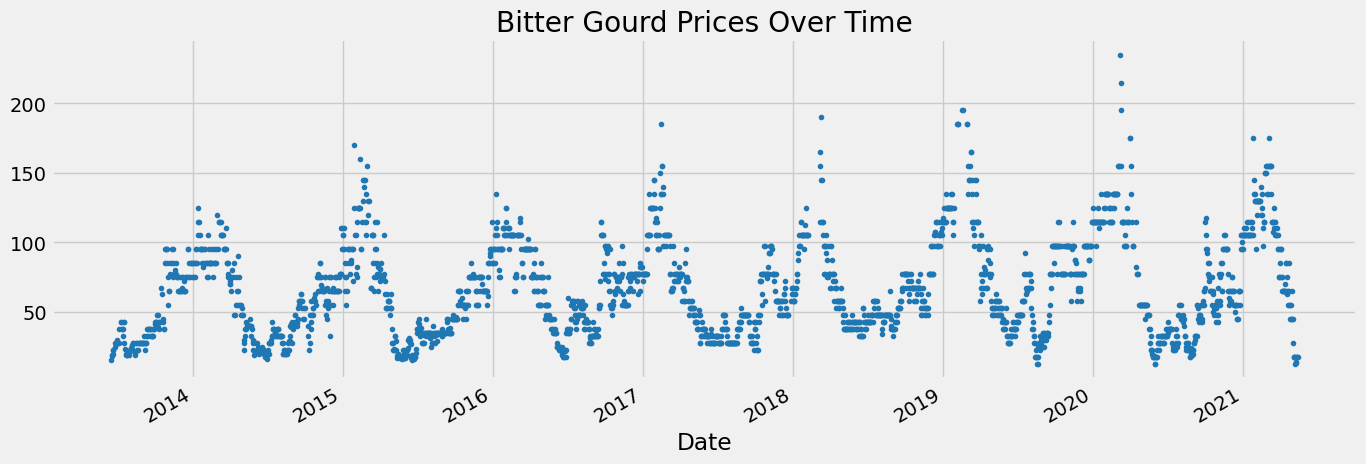

In [7]:
# Visualizing the time series data

bitter_gourd.plot(style = '.', figsize = (15,5), color = color_pal[0], title = 'Bitter Gourd Prices Over Time', legend = False)

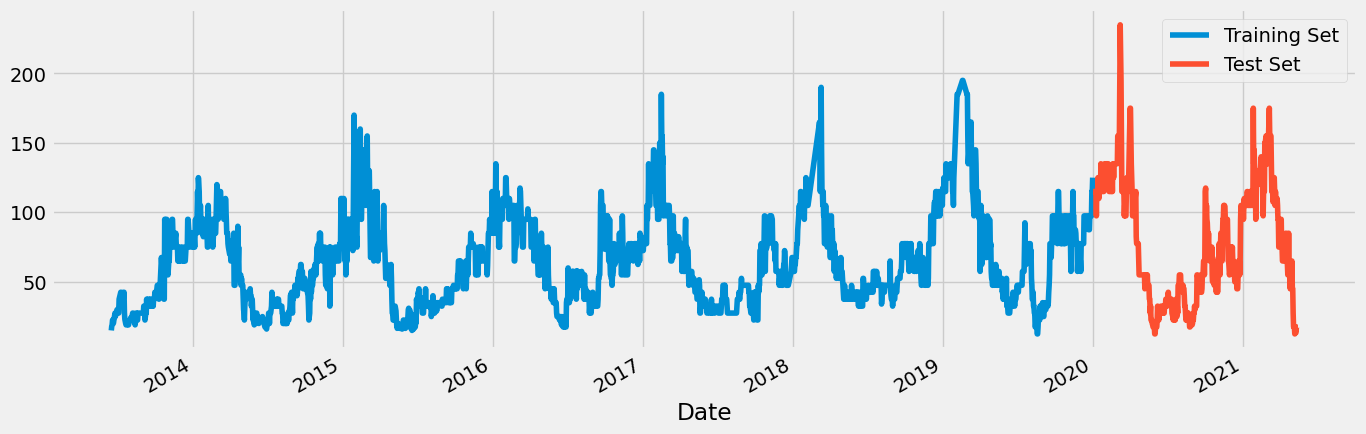

In [8]:
# Creating training and test sets; training set will be all data before 2020, test set wil be all data after 2020
train = bitter_gourd.loc[bitter_gourd.index <= '2019-12-31']
test = bitter_gourd.loc[bitter_gourd.index > '2019-12-31']

# Visualizing
fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax = ax, label = 'Training Set')
test.plot(ax = ax, label = 'Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [9]:
# Adding in the time series features to the original dataframe (before splitting into training and test sets) 
# to make sure that it's working properly 

bitter_gourd = create_features(bitter_gourd)
bitter_gourd

,Commodity,Price,DayofWeek,Month,Year,DayofYear
Date,,,,,,
2013-06-16,Bitter Gourd,15.0,6,6,2013,167
2013-06-17,Bitter Gourd,18.0,0,6,2013,168
2013-06-18,Bitter Gourd,19.0,1,6,2013,169
2013-06-19,Bitter Gourd,22.5,2,6,2013,170
2013-06-20,Bitter Gourd,22.5,3,6,2013,171
...,...,...,...,...,...,...
2021-05-09,Bitter Gourd,13.5,6,5,2021,129
2021-05-10,Bitter Gourd,17.5,0,5,2021,130
2021-05-11,Bitter Gourd,17.5,1,5,2021,131


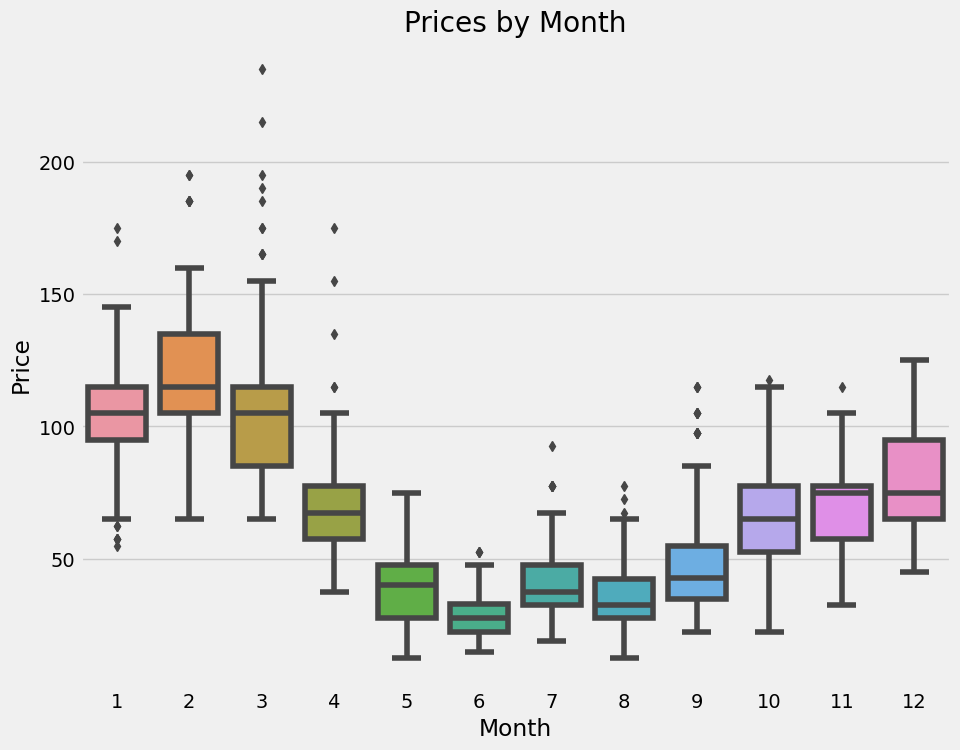

In [10]:
# Creating boxplots of prices per month

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=bitter_gourd, x='Month', y='Price')
ax.set_title('Prices by Month')
plt.show()

In [11]:
# Creating the time series features in the training and test sets 

train = create_features(train)
test = create_features(test)

In [12]:
# Labeling out feature and target variables

FEATURES = ['DayofWeek', 'Month', 'Year', 'DayofYear']
TARGET = 'Price'

In [13]:
x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

In [14]:
# Creating the model 

reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50, learning_rate = 0.01)
reg.fit(x_train, y_train,
        eval_set = [(x_train, y_train), (x_test, y_test)],
        verbose = 100)

[0]	validation_0-rmse:30.34054	validation_1-rmse:44.14447
[100]	validation_0-rmse:15.50418	validation_1-rmse:22.80825
[174]	validation_0-rmse:11.68364	validation_1-rmse:23.12007


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
# Feature importance 

fi = pd.DataFrame(data = reg.feature_importances_,
             index = reg.feature_names_in_,
             columns = ['importance'])
fi.sort_values(by = 'importance', ascending = False)

,importance
Month,0.462943
DayofYear,0.441205
Year,0.091218
DayofWeek,0.004634


<AxesSubplot:title={'center':'Feature Importance'}>

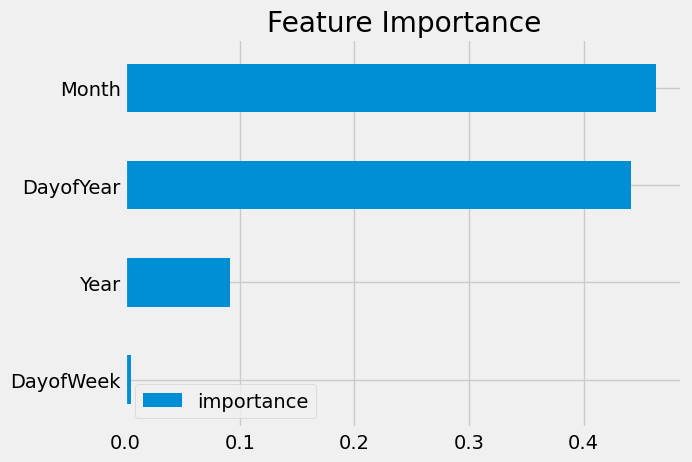

In [16]:
fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')

In [17]:
# Creating a new column in the test dataframe that stores the value that our model predicted for each date

test['prediction'] = reg.predict(x_test)
test

,Commodity,Price,DayofWeek,Month,Year,DayofYear,prediction
Date,,,,,,,
2020-01-01,Bitter Gourd,115.0,2,1,2020,1,103.897240
2020-01-02,Bitter Gourd,115.0,3,1,2020,2,103.897240
2020-01-03,Bitter Gourd,115.0,4,1,2020,3,103.897240
2020-01-04,Bitter Gourd,115.0,5,1,2020,4,103.897240
2020-01-05,Bitter Gourd,115.0,6,1,2020,5,103.897240
...,...,...,...,...,...,...,...
2021-05-09,Bitter Gourd,13.5,6,5,2021,129,51.177933
2021-05-10,Bitter Gourd,17.5,0,5,2021,130,51.076237
2021-05-11,Bitter Gourd,17.5,1,5,2021,131,51.076237


In [18]:
# Taking the predicted values and merging them into the original dataframe so we can see the predicted values and the 
# actual values side by side 

bitter_gourd = bitter_gourd.merge(test[['prediction']], how = 'left', left_index = True, right_index = True)
bitter_gourd

,Commodity,Price,DayofWeek,Month,Year,DayofYear,prediction
Date,,,,,,,
2013-06-16,Bitter Gourd,15.0,6,6,2013,167,NaN
2013-06-17,Bitter Gourd,18.0,0,6,2013,168,NaN
2013-06-18,Bitter Gourd,19.0,1,6,2013,169,NaN
2013-06-19,Bitter Gourd,22.5,2,6,2013,170,NaN
2013-06-20,Bitter Gourd,22.5,3,6,2013,171,NaN
...,...,...,...,...,...,...,...
2021-05-09,Bitter Gourd,13.5,6,5,2021,129,51.177933
2021-05-10,Bitter Gourd,17.5,0,5,2021,130,51.076237
2021-05-11,Bitter Gourd,17.5,1,5,2021,131,51.076237


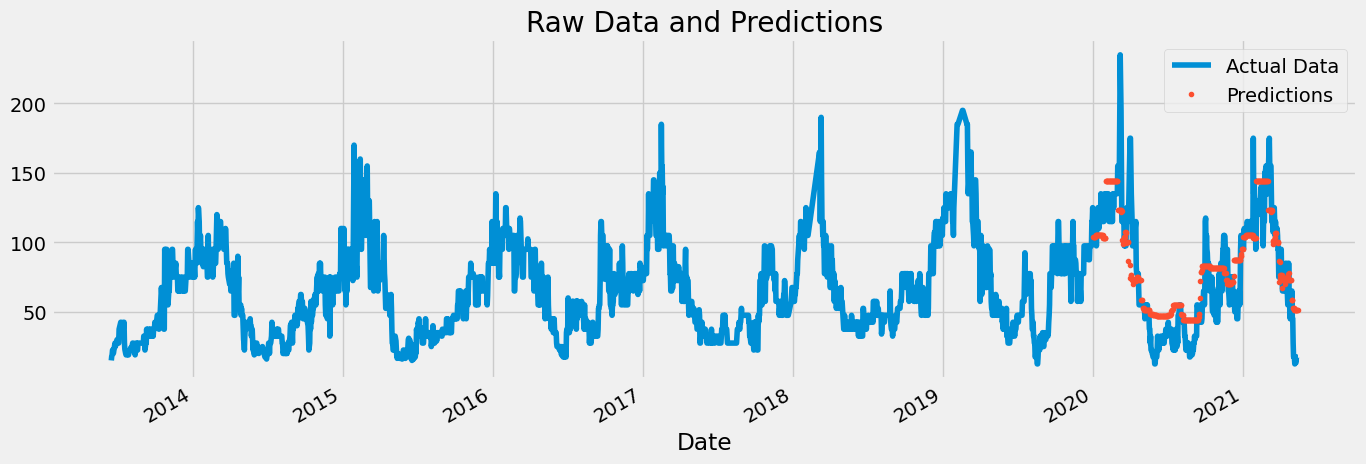

In [19]:
# Visualizing the predicted values on top of the actual values 

ax = bitter_gourd[['Price']].plot(figsize = (15, 5))
bitter_gourd['prediction'].plot(ax = ax, style = '.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

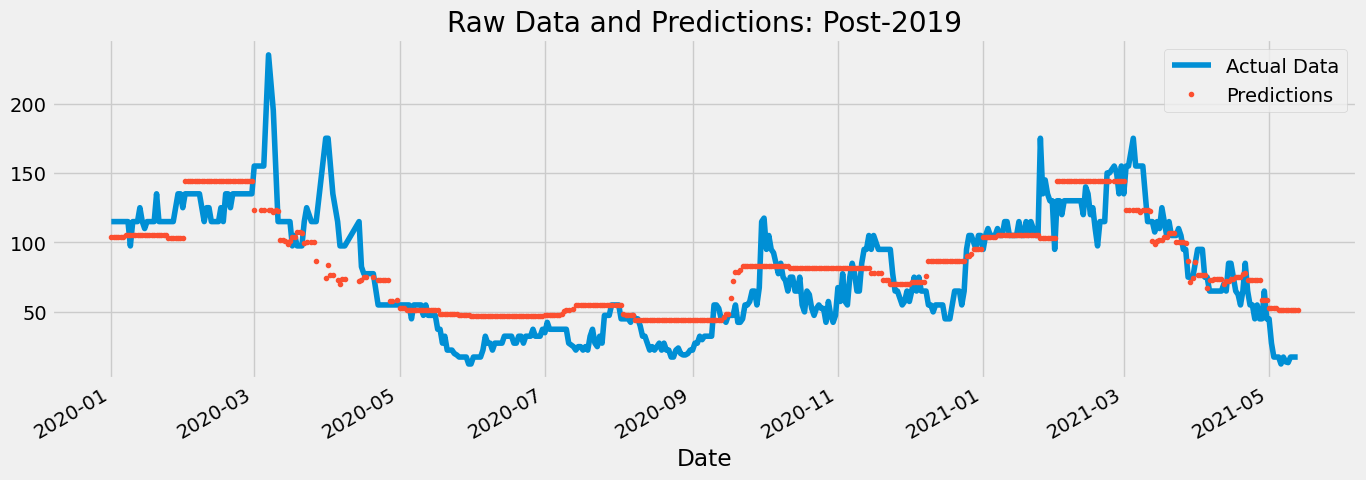

In [20]:
# Visualizing the predicted values on top of the actual values for the year of 2020 only 

ax = bitter_gourd.loc[bitter_gourd.index > '2019-12-31']['Price'] \
    .plot(figsize=(15, 5), title='Post-2019 Data')
bitter_gourd.loc[bitter_gourd.index > '2019-12-31']['prediction'] \
    .plot(style='.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Raw Data and Predictions: Post-2019')
plt.show()

In [21]:
# Calculating accuracy of model (root mean squared error; same metric used to evaluate model as it trained

eval_score = np.sqrt(mean_squared_error(test[TARGET], test['prediction']))
print(f'RMSE Score on Test set: {eval_score:0.2f}')

RMSE Score on Test set: 22.20


In [22]:
# Calculating error of model as a new column on our test dataframe

test['error'] = np.abs(test[TARGET] - test['prediction'])
test

,Commodity,Price,DayofWeek,Month,Year,DayofYear,prediction,error
Date,,,,,,,,
2020-01-01,Bitter Gourd,115.0,2,1,2020,1,103.897240,11.102760
2020-01-02,Bitter Gourd,115.0,3,1,2020,2,103.897240,11.102760
2020-01-03,Bitter Gourd,115.0,4,1,2020,3,103.897240,11.102760
2020-01-04,Bitter Gourd,115.0,5,1,2020,4,103.897240,11.102760
2020-01-05,Bitter Gourd,115.0,6,1,2020,5,103.897240,11.102760
...,...,...,...,...,...,...,...,...
2021-05-09,Bitter Gourd,13.5,6,5,2021,129,51.177933,37.677933
2021-05-10,Bitter Gourd,17.5,0,5,2021,130,51.076237,33.576237
2021-05-11,Bitter Gourd,17.5,1,5,2021,131,51.076237,33.576237


In [23]:
# Seeing which months our model predicts the best for 

test.groupby('Month')['error'].mean().sort_values()

Month
1     11.655862
11    14.514449
8     14.853577
2     16.133498
4     17.292662
9     17.759865
7     17.783950
6     18.247625
5     19.699147
12    20.016075
10    20.287103
3     20.965396
Name: error, dtype: float64

In [24]:
# Evaluating the model against a comparison model: predictions that are just the average for each month from the training set

# Creating a new dataframe that holds this information

# Getting just the month and price columns from the training set dataframe
monthly_averages = train[['Month', 'Price']]
monthly_averages = monthly_averages.reset_index(drop=True)

# Calculating the average price for each month 
monthly_averages = monthly_averages.groupby('Month')['Price'].mean().reset_index()
monthly_averages

,Month,Price
0,1,100.491018
1,2,110.482456
2,3,100.277778
3,4,68.644118
4,5,39.934659
5,6,29.182796
6,7,41.312796
7,8,34.674757
8,9,48.529703
9,10,66.045918


In [25]:
# Merging monthly average information into the test dataframe to be able to calculate the comparison model's errors

# Renaming 'Price' column in monthly_averages dataframe to 'CompPrediction' so that the original Price column name isn't changed 
monthly_averages.rename(columns = {'Price': 'CompPrediction'}, inplace = True)

test = test.merge(monthly_averages, on='Month', how='left')
test

,Commodity,Price,DayofWeek,Month,Year,DayofYear,prediction,error,CompPrediction
0,Bitter Gourd,115.0,2,1,2020,1,103.897240,11.102760,100.491018
1,Bitter Gourd,115.0,3,1,2020,2,103.897240,11.102760,100.491018
2,Bitter Gourd,115.0,4,1,2020,3,103.897240,11.102760,100.491018
3,Bitter Gourd,115.0,5,1,2020,4,103.897240,11.102760,100.491018
4,Bitter Gourd,115.0,6,1,2020,5,103.897240,11.102760,100.491018
...,...,...,...,...,...,...,...,...,...
472,Bitter Gourd,13.5,6,5,2021,129,51.177933,37.677933,39.934659
473,Bitter Gourd,17.5,0,5,2021,130,51.076237,33.576237,39.934659
474,Bitter Gourd,17.5,1,5,2021,131,51.076237,33.576237,39.934659
475,Bitter Gourd,17.5,2,5,2021,132,51.076237,33.576237,39.934659


In [26]:
# Calculating the comparison model's error
test['CompError'] = np.abs(test[TARGET] - test['CompPrediction'])
test

,Commodity,Price,DayofWeek,Month,Year,DayofYear,prediction,error,CompPrediction,CompError
0,Bitter Gourd,115.0,2,1,2020,1,103.897240,11.102760,100.491018,14.508982
1,Bitter Gourd,115.0,3,1,2020,2,103.897240,11.102760,100.491018,14.508982
2,Bitter Gourd,115.0,4,1,2020,3,103.897240,11.102760,100.491018,14.508982
3,Bitter Gourd,115.0,5,1,2020,4,103.897240,11.102760,100.491018,14.508982
4,Bitter Gourd,115.0,6,1,2020,5,103.897240,11.102760,100.491018,14.508982
...,...,...,...,...,...,...,...,...,...,...
472,Bitter Gourd,13.5,6,5,2021,129,51.177933,37.677933,39.934659,26.434659
473,Bitter Gourd,17.5,0,5,2021,130,51.076237,33.576237,39.934659,22.434659
474,Bitter Gourd,17.5,1,5,2021,131,51.076237,33.576237,39.934659,22.434659
475,Bitter Gourd,17.5,2,5,2021,132,51.076237,33.576237,39.934659,22.434659


In [27]:
# Calculating RMSE for the comparison model 
comp_eval_score = np.sqrt(mean_squared_error(test[TARGET], test['CompPrediction']))
print(f'RMSE Score on Test set: {comp_eval_score:0.2f}')

RMSE Score on Test set: 22.83


In [28]:
# Calculating how much more accurate our model is than the comparison model 
percentage_difference = ((comp_eval_score - eval_score) / comp_eval_score) * 100 
print(f'Our model is {percentage_difference:f}% more accurate than the comparison model')

Our model is 2.727543% more accurate than the comparison model
